### Importing libraries and data

In [4]:
# !pip install lightgbm
# !pip install seaborn --upgrade
# !pip install shap

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier, plot_importance as plot_importance_lgbm

import re
from scipy import stats
from tqdm import tqdm
import glob
import time
import random
import shap

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, roc_curve, auc, roc_auc_score, precision_recall_curve

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from utils import clean_text, cap_values, categorize_value, calculate_risk_score, preprocess_data, evaluate_model, tune_model, \
 train_models, load_models, load_model_params

random.seed(42)

#### Feature sets for train data

In [3]:
with open(r'.\dumps\train_feature_sets.pkl', 'rb') as f:
    train_feature_sets = pickle.load(f)

train_feature_sets.keys()

dict_keys(['[X_tr_imb, y_tr_imb]', '[X_tr_smote, y_tr_smote]', '[X_tr_std, y_tr_std]', '[X_tr_smote_std, y_tr_smote]'])

#### Feature sets for test data

In [5]:
with open(r'.\data_for_model\test\test_data.pkl', 'rb') as f:
    X_test, y_test = pickle.load(f)

X_test.shape, y_test.shape

((138, 11), (138,))

In [6]:
X_test = preprocess_data(X_test)
X_test.head(2)

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,New_Risk_Score,Sex,FastingBS,ExerciseAngina,ChestPainType_asy,...,RestingECG_lvh,RestingECG_normal,RestingECG_st,ST_Slope_down,ST_Slope_flat,ST_Slope_up,New_Cholesterol_Bin_high,New_Cholesterol_Bin_low,New_Cholesterol_Bin_medium,New_Cholesterol_Bin_zero
0,51,125,188,145,0.0,2,1,0,0,0,...,0,1,0,0,0,1,0,1,0,0
1,70,130,322,109,2.4,8,1,0,0,1,...,1,0,0,0,1,0,1,0,0,0


In [7]:
# Feature columns

with open(r'.\dumps\num_FE_features.pkl', 'rb') as f:
    num_FE_features = pickle.load(f)

with open(r'.\dumps\numeric_columns.pkl', 'rb') as f:
    numeric_cols = pickle.load(f)

with open(r'.\dumps\mapping_features.pkl', 'rb') as f:
    mapping_features = pickle.load(f)

with open(r'.\dumps\one_hot_encoder_feature_names.pkl', 'rb') as f:
    one_hot_encoder_feature_names = pickle.load(f)

num_cols = numeric_cols + num_FE_features

In [8]:
with open(r'.\dumps\2_standardscaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

num_scaled = pd.DataFrame(scaler.transform(X_test[num_cols]), columns=num_cols)
X_te_std = pd.concat([num_scaled, X_test[mapping_features], X_test[one_hot_encoder_feature_names]], axis=1)

In [9]:
with open(r'.\dumps\3_smote_standardscaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

num_scaled = pd.DataFrame(scaler.transform(X_test[num_cols]), columns=num_cols)
X_te_smote_std = pd.concat([num_scaled, X_test[mapping_features], X_test[one_hot_encoder_feature_names]], axis=1)

In [10]:
test_feature_sets = {
    '[X_test, y_test]' : [X_test, y_test],
    '[X_te_std, y_test]' : [X_te_std, y_test],
    '[X_te_smote_std, y_test]' : [X_te_smote_std, y_test]  
}

with open(r'.\dumps\test_feature_sets.pkl', 'wb') as f:
    pickle.dump(test_feature_sets, f)

### Training Models

In [12]:
%%time
random.seed(42)

results = []
results += train_models('[X_tr_imb, y_tr_imb]', '[X_test, y_test]')
results += train_models('[X_tr_smote, y_tr_smote]', '[X_test, y_test]')

results += train_models('[X_tr_std, y_tr_std]', '[X_te_std, y_test]')
results += train_models('[X_tr_smote_std, y_tr_smote]', '[X_te_smote_std, y_test]')

 50%|██████████████████████████████████████████                                          | 3/6 [00:00<00:00, 28.85it/s]

[LightGBM] [Info] Number of positive: 432, number of negative: 348
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 780, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553846 -> initscore=0.216223
[LightGBM] [Info] Start training from score 0.216223
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.53it/s]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 50%|██████████████████████████████████████████                                          | 3/6 [00:00<00:00, 26.67it/s]

[LightGBM] [Info] Number of positive: 432, number of negative: 432
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 438
[LightGBM] [Info] Number of data points in the train set: 864, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:00<00:00, 21.54it/s]

[LightGBM] [Info] Number of positive: 432, number of negative: 348
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 780, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553846 -> initscore=0.216223
[LightGBM] [Info] Start training from score 0.216223
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 12.01it/s]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:00<00:00, 18.50it/s]

[LightGBM] [Info] Number of positive: 432, number of negative: 432
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 441
[LightGBM] [Info] Number of data points in the train set: 864, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.62it/s]

CPU times: total: 5.61 s
Wall time: 2.27 s


In [21]:
results_df = pd.DataFrame(results)
results_df.sort_values(by=['test_f1_micro'], ascending=[False], inplace=True)
results_df

,Model,train_data,test_data,train_f1_micro,test_f1_micro,train_f1_macro,test_f1_macro,train_f1_weighted,test_f1_weighted
20,SVC,"[X_tr_smote_std, y_tr_smote]","[X_te_smote_std, y_test]",0.9109,0.9203,0.9108,0.9196,0.9108,0.9203
22,Random Forest,"[X_tr_smote_std, y_tr_smote]","[X_te_smote_std, y_test]",1.0000,0.9130,1.0000,0.9121,1.0000,0.9130
10,Random Forest,"[X_tr_smote, y_tr_smote]","[X_test, y_test]",1.0000,0.9058,1.0000,0.9047,1.0000,0.9057
18,Logistic Regression,"[X_tr_smote_std, y_tr_smote]","[X_te_smote_std, y_test]",0.8796,0.9058,0.8796,0.9050,0.8796,0.9059
16,Random Forest,"[X_tr_std, y_tr_std]","[X_te_std, y_test]",1.0000,0.9058,1.0000,0.9047,1.0000,0.9057
12,Logistic Regression,"[X_tr_std, y_tr_std]","[X_te_std, y_test]",0.8679,0.8986,0.8657,0.8975,0.8676,0.8986
4,Random Forest,"[X_tr_imb, y_tr_imb]","[X_test, y_test]",1.0000,0.8986,1.0000,0.8975,1.0000,0.8986
14,SVC,"[X_tr_std, y_tr_std]","[X_te_std, y_test]",0.9013,0.8913,0.8995,0.8896,0.9009,0.8910
11,LightGBM,"[X_tr_smote, y_tr_smote]","[X_test, y_test]",1.0000,0.8913,1.0000,0.8908,1.0000,0.8916
23,LightGBM,"[X_tr_smote_std, y_tr_smote]","[X_te_smote_std, y_test]",1.0000,0.8913,1.0000,0.8908,1.0000,0.8916


**Observation:**

    1. Random Forest and SVC are top models to tune
    2. [X_tr_smote_std, y_tr_smote] is top data feature set
    3. RF top model and 3rd model is slightly overfitting
    4. SVC 2nd top model is slightly underfitting to correct fit 

#### Tuning top models

In [24]:
results_df[:3]

,Model,train_data,test_data,train_f1_micro,test_f1_micro,train_f1_macro,test_f1_macro,train_f1_weighted,test_f1_weighted
20,SVC,"[X_tr_smote_std, y_tr_smote]","[X_te_smote_std, y_test]",0.9109,0.9203,0.9108,0.9196,0.9108,0.9203
22,Random Forest,"[X_tr_smote_std, y_tr_smote]","[X_te_smote_std, y_test]",1.0000,0.9130,1.0000,0.9121,1.0000,0.9130
10,Random Forest,"[X_tr_smote, y_tr_smote]","[X_test, y_test]",1.0000,0.9058,1.0000,0.9047,1.0000,0.9057


In [85]:
%%time
random.seed(42)
results = []
results += train_models('[X_tr_imb, y_tr_imb]', '[X_test, y_test]', tune=True, scoring=['accuracy', 'f1'], models={'Random Forest': RandomForestClassifier()})

results += train_models('[X_tr_smote_std, y_tr_smote]', '[X_te_smote_std, y_test]', tune=True, scoring=['accuracy', 'f1'], models={'Random Forest': RandomForestClassifier(),
                                                                                                                                                'SVC': SVC()})

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


 50%|██████████████████████████████████████████                                          | 1/2 [00:08<00:08,  8.25s/it]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.58s/it]

CPU times: total: 3.27 s
Wall time: 17.3 s


In [86]:
results_df = pd.DataFrame(results)
results_df.sort_values(by=['test_f1_micro'], ascending=[False], inplace=True)
results_df

,Model,train_data,test_data,train_f1_micro,test_f1_micro,train_f1_macro,test_f1_macro,train_f1_weighted,test_f1_weighted
1,Random Forest,"[X_tr_smote_std, y_tr_smote]","[X_te_smote_std, y_test]",0.9028,0.9058,0.9027,0.9050,0.9027,0.9059
0,Random Forest,"[X_tr_imb, y_tr_imb]","[X_test, y_test]",0.8962,0.8841,0.8940,0.8821,0.8956,0.8836
2,SVC,"[X_tr_smote_std, y_tr_smote]","[X_te_smote_std, y_test]",0.8796,0.8768,0.8796,0.8749,0.8796,0.8765


**Observation:**

      1. We can see that all three models are fit correctly
      2. We can see that Random Forest with smote upsampled and standard scaled data is performing best

#### Top model and feature set selected

In [37]:
models = load_models()
model_params = load_model_params()

In [39]:
model = models['Random Forest']
param_grid = model_params['Random Forest']

In [103]:
random.seed(42)
best_model, best_score = tune_model('random', model, param_grid, train_feature_sets['[X_tr_smote_std, y_tr_smote]'][0], 
                        train_feature_sets['[X_tr_smote_std, y_tr_smote]'][1], scoring=['accuracy', 'f1'], n_iter=20, cv=4, random_state=42)

print('Best model parameters:', best_model.get_params())
print('\n')
print('Best score:', best_score)

Fitting 4 folds for each of 20 candidates, totalling 80 fits
Best model parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 80, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 8, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1000, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


Best score: 0.8831018518518519


micro f1_score- train_f1_micro: 0.9028 test_f1_micro: 0.9058 

Classification Report on train data:
               precision    recall  f1-score   support

           0       0.93      0.87      0.90       432
           1       0.88      0.93      0.91       432

    accuracy                           0.90       864
   macro avg       0.90      0.90      0.90       864
weighted avg       0.90      0.90      0.90       864
 

Classification Report on test data:
               precision    recall  f1-score   support

           0       0.89      0.90      0.90        62
           1       0.92      0.91      0.91        76

    accuracy                           0.91       138
   macro avg       0.90      0.91      0.90       138
weighted avg       0.91      0.91      0.91       138





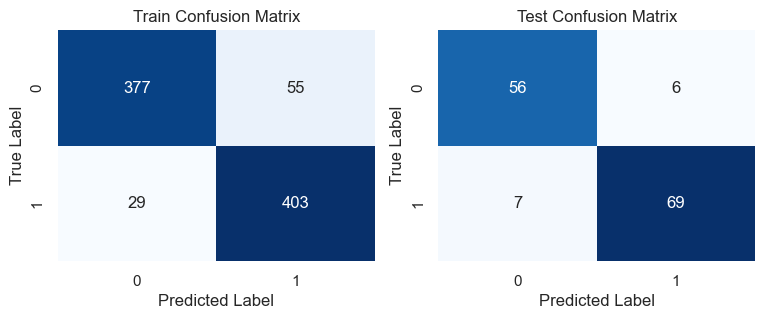

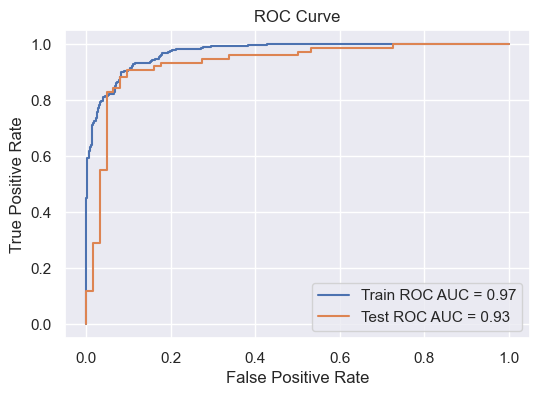

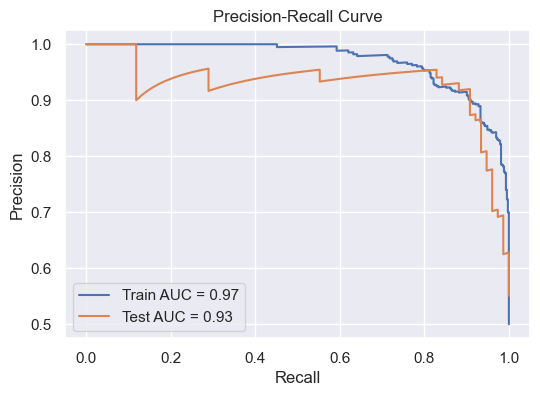

In [105]:
evaluate_model(best_model, train_feature_sets['[X_tr_smote_std, y_tr_smote]'][0], 
               train_feature_sets['[X_tr_smote_std, y_tr_smote]'][1], X_te_smote_std, y_test)

In [107]:
with open(r'.\final_model\train_data.pkl', 'wb') as f:
    pickle.dump(train_feature_sets['[X_tr_smote_std, y_tr_smote]'], f)

with open(r'.\final_model\test_data.pkl', 'wb') as f:
    pickle.dump([X_te_smote_std, y_test], f)

with open(r'.\final_model\final_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

best_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 80,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 8,
 'min_samples_split': 6,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

#### Feature Importance

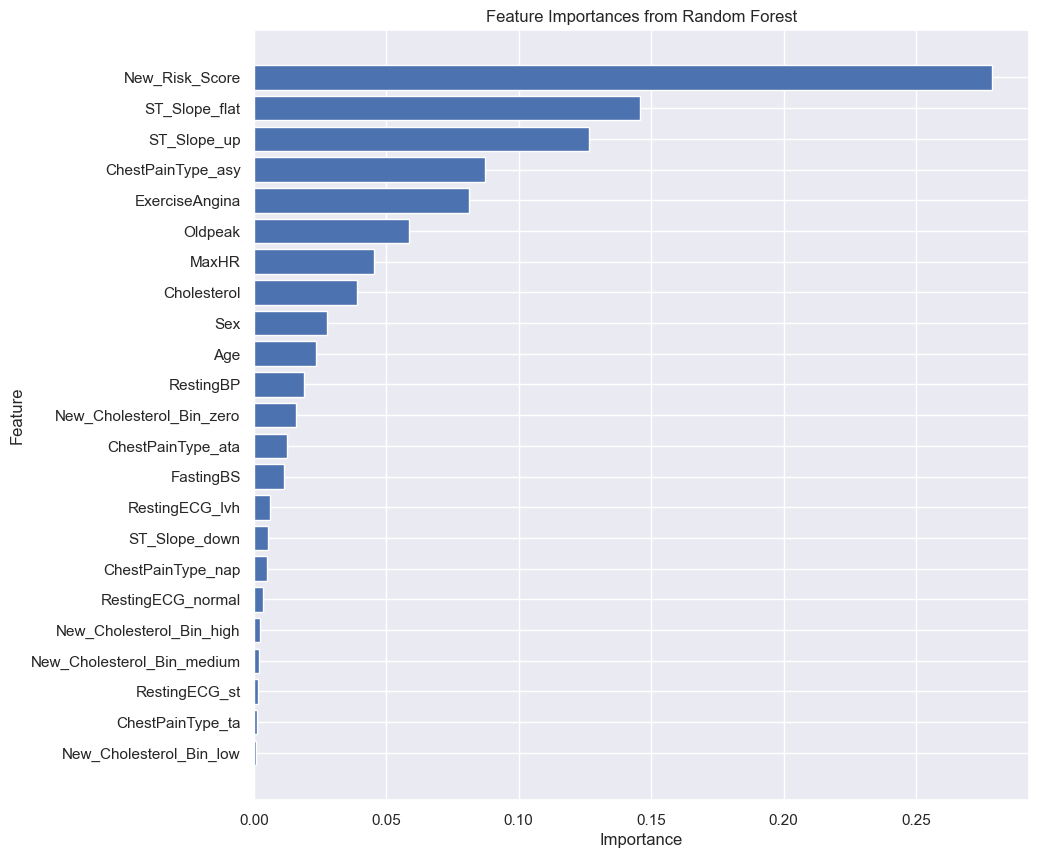

In [126]:
# Extract coefficients and feature names
importances = best_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance= pd.DataFrame({
    'Feature': X_te_smote_std.columns,
    'Importance': importances,
    'Absolute_Importance': np.abs(importances)
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 10))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()
plt.show()

In [127]:
feature_importance['%age_explanability'] = round(feature_importance['Absolute_Importance'] / feature_importance['Absolute_Importance'].sum() * 100,2)
feature_importance

,Feature,Importance,Absolute_Importance,%age_explanability
0,New_Risk_Score,0.278675,0.278675,27.87
1,ST_Slope_flat,0.145690,0.145690,14.57
2,ST_Slope_up,0.126432,0.126432,12.64
3,ChestPainType_asy,0.087279,0.087279,8.73
4,ExerciseAngina,0.081119,0.081119,8.11
5,Oldpeak,0.058653,0.058653,5.87
6,MaxHR,0.045441,0.045441,4.54
7,Cholesterol,0.038880,0.038880,3.89
8,Sex,0.027481,0.027481,2.75
9,Age,0.023274,0.023274,2.33


**Lets try with tune the model with top 14 features**

In [173]:
# variance explained by top 14 features
feature_importance[feature_importance['%age_explanability'] >= 1]['%age_explanability'].sum()

97.17999999999999

In [175]:
Top_features = feature_importance[feature_importance['%age_explanability'] >= 1]['Feature'].to_list()
Top_features

['New_Risk_Score',
 'ST_Slope_flat',
 'ST_Slope_up',
 'ChestPainType_asy',
 'ExerciseAngina',
 'Oldpeak',
 'MaxHR',
 'Cholesterol',
 'Sex',
 'Age',
 'RestingBP',
 'New_Cholesterol_Bin_zero',
 'ChestPainType_ata',
 'FastingBS']

In [177]:
# train data
X_train_sel_features = train_feature_sets['[X_tr_smote_std, y_tr_smote]'][0][Top_features]
y_train_sel = train_feature_sets['[X_tr_smote_std, y_tr_smote]'][1]

# test_data
X_te_sel = X_te_smote_std[Top_features]

In [179]:
random.seed(42)
best_model, best_score = tune_model('random', model, param_grid, X_train_sel_features, 
                        y_train_sel, scoring=['accuracy', 'f1'], n_iter=20, cv=4, random_state=42)

print('Best model parameters:', best_model.get_params())
print('\n')
print('Best score:', best_score)

Fitting 4 folds for each of 20 candidates, totalling 80 fits
Best model parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 100, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': 0.7, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 6, 'min_samples_split': 12, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 800, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


Best score: 0.8819444444444444


micro f1_score- train_f1_micro: 0.9051 test_f1_micro: 0.8913 

Classification Report on train data:
               precision    recall  f1-score   support

           0       0.93      0.88      0.90       432
           1       0.88      0.93      0.91       432

    accuracy                           0.91       864
   macro avg       0.91      0.91      0.91       864
weighted avg       0.91      0.91      0.91       864
 

Classification Report on test data:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88        62
           1       0.90      0.91      0.90        76

    accuracy                           0.89       138
   macro avg       0.89      0.89      0.89       138
weighted avg       0.89      0.89      0.89       138





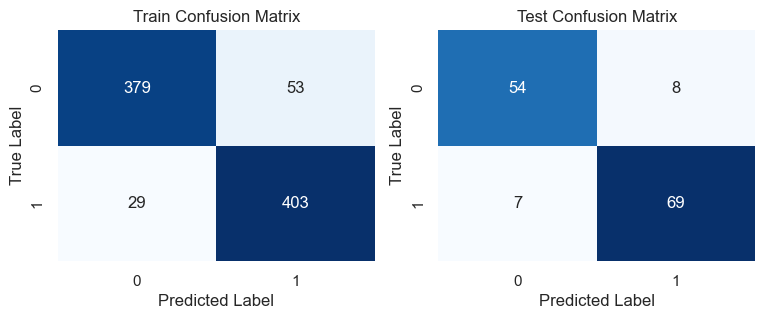

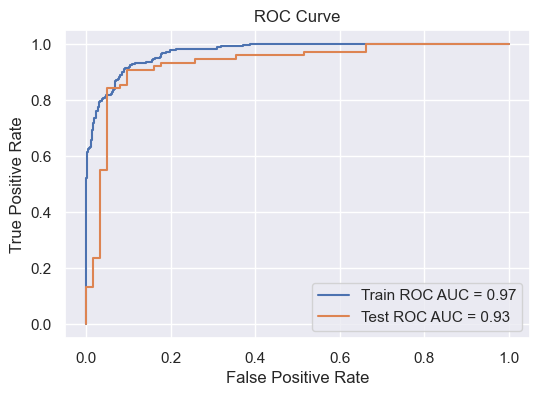

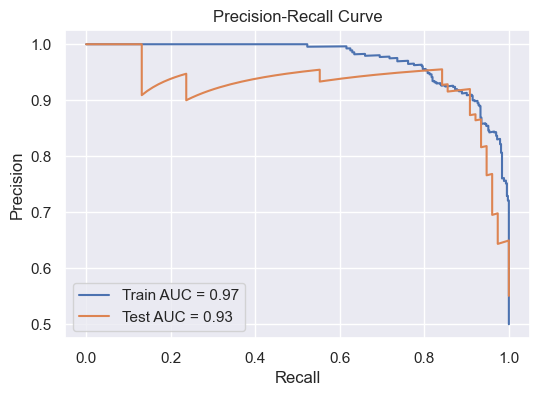

In [180]:
evaluate_model(best_model, X_train_sel_features, y_train_sel, X_te_sel, y_test)

**Observation:** 

    1. We can see that model performance drop very marginally with top 14 features.
    2. Performance metric varies more even with one mis-classification as data size is low.
    3. For now, lets keep all the features in our model